# koan_5 — CNN for MNIST classification

The purpose of this notebook is to build a classic
CNN classifier for the simple MNIST dataset.

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tqdm import tqdm

## Load the MNIST data

In [2]:
# We'll load the data so that it's normalized, meaning that we push
# the mean toward 0, with channel values ending up around [-1, 1] or so.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True,  transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [3]:
# Inspect a single element to see what this data is like.
image, label = train_dataset[0]

In [4]:
image.shape, label

(torch.Size([1, 28, 28]), 5)

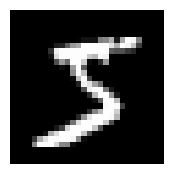

In [5]:
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(image.squeeze(), cmap='gray');

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

## Set up the model

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.cnn_layer(x)
        x = self.fc_layer(x)
        return x

## Define training and evaluation processes

In [8]:
def train(model, device, loader, loss_fn, opt, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        
        loss_sum = 0
        
        for images, labels in tqdm(loader):
            
            images = images.to(device)
            labels = labels.to(device)

            opt.zero_grad()
            pred = model(images)
            loss = loss_fn(pred, labels)
            loss.backward()
            opt.step()

            loss_sum += loss.item()

        avg_loss = loss_sum / len(loader)
        print(f'Epoch {epoch + 1}/{num_epochs}. Loss {avg_loss:.4f}')

In [22]:
def evaluate(model, device, loader):
    num_correct = 0
    total_inputs = 0
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(loader):
            
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            _, pred = torch.max(pred, 1)

            total_inputs += labels.size(0)
            num_correct += (pred == labels).sum().item()

    acc = 100 * num_correct / total_inputs
    print(f'Accuracy {acc:.2f}%')

## Train and evaluate

In [10]:
# Determine which device to use.
device = 'cpu'
if torch.cuda.is_available():
    device = 'gpu'
elif torch.backends.mps.is_available():
    device = 'mps'

In [11]:
# Hack because my python kernel dies with device="mps".
device = 'cpu'

In [12]:
# Set up the model, loss function, and optimizer.
model   = SimpleCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
opt     = optim.Adam(model.parameters(), lr=0.001)

In [13]:
train(model, device, train_loader, loss_fn, opt)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:04<00:00, 14.52it/s]


Epoch 1/5. Loss 0.1644


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:00<00:00, 15.43it/s]


Epoch 2/5. Loss 0.0438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:03<00:00, 14.84it/s]


Epoch 3/5. Loss 0.0320


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:02<00:00, 15.01it/s]


Epoch 4/5. Loss 0.0233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [01:05<00:00, 14.38it/s]

Epoch 5/5. Loss 0.0172


In [23]:
evaluate(model, device, test_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 45.88it/s]

Accuracy 99.05%
